In [110]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
import random

In [111]:
vulnerable = 1
infected = 2
recovered = 3
died = 4

probToLoseImmunity = 0.2
immunityTicks = 5
contagiousnessIndex = 0.05
dieProbability = 0.02
daysInIllness = 14
vaccinePerDay = 10
quarantineMultiplier = 0.2

In [112]:
%%time

def initNewGraph(nodeCount):
    expectationForOneNode = 2
    g = nx.Graph()

    g.add_node("v1", state=vulnerable, daysOfIllnessLeft=0, immunityTicks=0)
    g.add_node("v2", state=vulnerable, daysOfIllnessLeft=0, immunityTicks=0)
    g.add_node("v3", state=vulnerable, daysOfIllnessLeft=0, immunityTicks=0)

    g.add_edge("v1", "v2", weight=0.3)
    g.add_edge("v1", "v3", weight=0.3)
    g.add_edge("v2", "v3", weight=0.3)

    for i in range(4, nodeCount + 1):
        vrtx = list(g.nodes())
        newVRTX = f"v{i}"
        g.add_node(newVRTX, state=vulnerable, daysOfIllnessLeft=0, immunityTicks=0)

        totalWeightSum = sum([w for _, _, w in g.edges(data='weight')])
        for v in vrtx:
            weightSum = sum([w for _, _, w in g.edges(v, data='weight')])
            prob = rand.uniform(high=weightSum)

            g.add_edge(newVRTX, v, weight=prob / totalWeightSum * expectationForOneNode)

    return g


def graphWeightsDistribution(g):
    distribution = {}
    for v1, v2, w in g.edges(data='weight'):
        if v1 not in distribution:
            distribution[v1] = 0.0
        if v2 not in distribution:
            distribution[v2] = 0.0

        distribution[v1] += w
        distribution[v2] += w

    return distribution


def printGraphWeightsDistribution(weightsDistribution):
    values = list(weightsDistribution.values())

    # Create histogram
    plt.figure(figsize=(8, 6))
    plt.hist(values, bins=10, edgecolor='black')
    plt.title('Histogram of Weights')
    plt.xlabel('Weights')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


def printGraphWeightsPercentile(weightsDistribution):
    values = list(weightsDistribution.values())

    q1 = np.percentile(values, 25)
    q2 = np.percentile(values, 50)
    q3 = np.percentile(values, 75)
    minimum = np.percentile(values, 0)
    maximum = np.percentile(values, 100)

    print(f"q1={q1} q2={q2} q3={q3} min={minimum} max={maximum}")

CPU times: user 124 µs, sys: 220 µs, total: 344 µs
Wall time: 1.07 ms


In [113]:
def infect(node):
    node['state'] = infected
    node['daysOfIllnessLeft'] = daysInIllness

def kill(node):
    node['state'] = died

def recoverTick(node):
    node['daysOfIllnessLeft'] -= 1

    if  node['daysOfIllnessLeft'] == 0:
        node['state'] = recovered
        node['immunityTicks'] = immunityTicks


def loseImunityTick(node):
     node['immunityTicks']-= 1

     if node['immunityTicks'] == 0:
        node['state'] = vulnerable

def vaccinate(node):
    node['state'] = recovered
    node['immunityTicks'] = immunityTicks

def noVaccine(infected, died):
    return False

def vaccine(infected, died):
    return died > 10

def noQuarantine(infected, died):
    return False

def quarantine(infected, died):
    return infected > 30


In [124]:
def simulate(g, days, getQuarantine, getVaccine):
    nodes = g.nodes()
    infect(nodes["v5"])
    infect(nodes["v55"])
    infect(nodes["v155"])

    vulnerableHistory = []
    infectedHistory = []
    recoveredHistory = []
    diedHistory = []

    for day in range(days):
        vulnerableNodes =  [node for node, attrs in g.nodes(data=True) if attrs.get('state') == vulnerable]
        infectedNodes = [node for node, attrs in g.nodes(data=True) if attrs.get('state') == infected]
        recoveredNodes =  [node for node, attrs in g.nodes(data=True) if attrs.get('state') == recovered]
        diedNodes =  [node for node, attrs in g.nodes(data=True) if attrs.get('state') == died]

        vulnerableHistory.append(len(vulnerableNodes))
        infectedHistory.append(len(infectedNodes))
        recoveredHistory.append(len(recoveredNodes))
        diedHistory.append(len(diedNodes))

        if getVaccine(len(infectedNodes), len(diedNodes)):
            random.shuffle(vulnerableNodes)
            for node in vulnerableNodes[:min(len(vulnerableNodes)-1, vaccinePerDay)]:
                vaccinate(g.nodes[node])

        for node in infectedNodes:
            neighbors = list(g.neighbors(node))

            for neighbor in neighbors:
                if g.nodes[neighbor]['state'] == vulnerable:
                    p = g.get_edge_data(node, neighbor)['weight'] * contagiousnessIndex
                    if getQuarantine(len(infectedNodes), len(diedNodes)):
                        p *= quarantineMultiplier

                    if rand.uniform() < p:
                        infect(g.nodes[neighbor])

            if rand.uniform() < dieProbability:
                kill(g.nodes[node])
            else:
                recoverTick(g.nodes[node])

        for node in recoveredNodes:
            if rand.uniform() < probToLoseImmunity:
                loseImunityTick(g.nodes[node])

    return vulnerableHistory, infectedHistory, recoveredHistory, diedHistory

In [125]:
def draw(vulnerableHistory, infectedHistory, recoveredHistory, diedHistory):
    plt.plot(np.array(vulnerableHistory), label="vulnerable")
    plt.plot(np.array(infectedHistory), label="infected")
    plt.plot(np.array(recoveredHistory), label="recovered")
    plt.plot(np.array(diedHistory), label="died")

    plt.title('Population Status Over Time')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.ylabel('Population')

    plt.show()

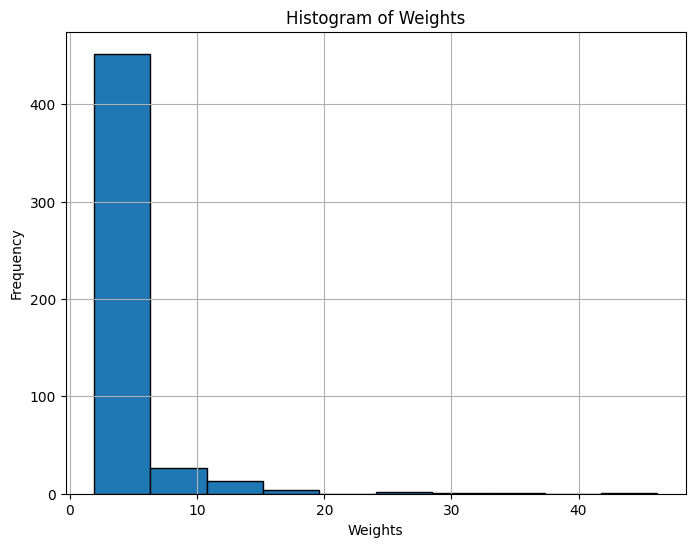

q1=2.298003472945481 q2=2.797246776993795 q3=3.9919089079472667 min=1.8757289829399495 max=46.20734704460077


In [126]:
g = initNewGraph(500)
dist = graphWeightsDistribution(g)

printGraphWeightsDistribution(dist)
printGraphWeightsPercentile(dist)

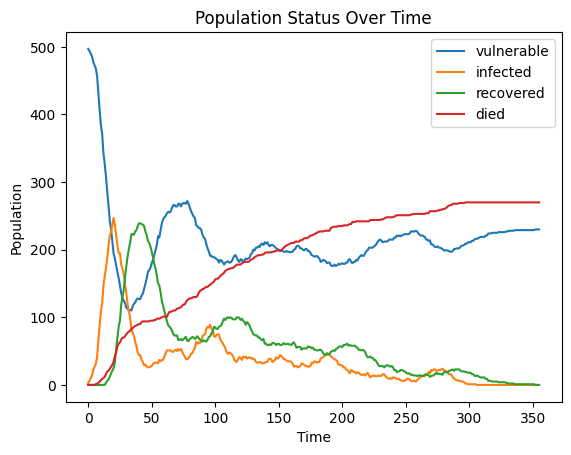

In [127]:
vulnerableHistory, infectedHistory, recoveredHistory, diedHistory = simulate(g, 356, noQuarantine, noVaccine)

draw(vulnerableHistory, infectedHistory, recoveredHistory, diedHistory)

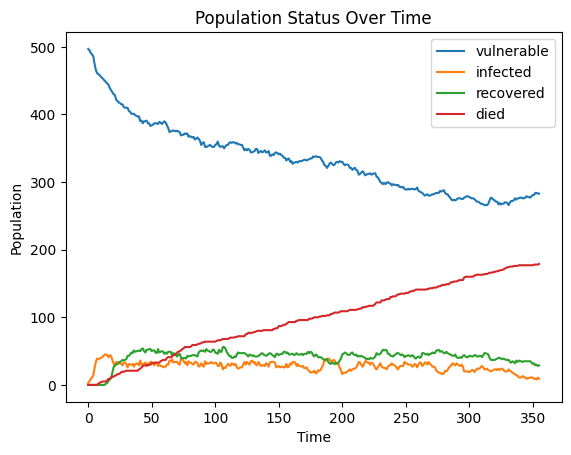

In [128]:
g = initNewGraph(500)
vulnerableHistory, infectedHistory, recoveredHistory, diedHistory = simulate(g, 356, quarantine, noVaccine)

draw(vulnerableHistory, infectedHistory, recoveredHistory, diedHistory)

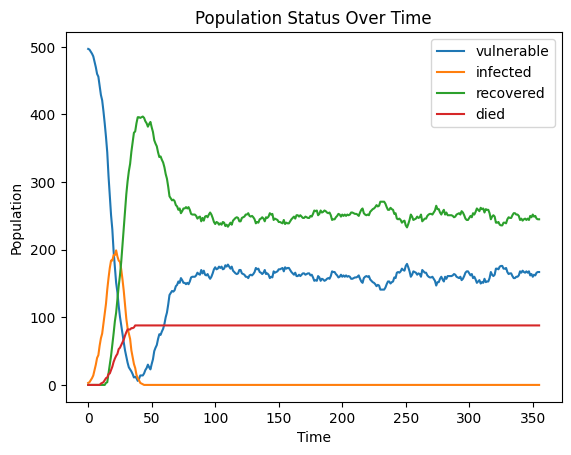

In [129]:
g = initNewGraph(500)
vulnerableHistory, infectedHistory, recoveredHistory, diedHistory = simulate(g, 356, noQuarantine, vaccine)

draw(vulnerableHistory, infectedHistory, recoveredHistory, diedHistory)

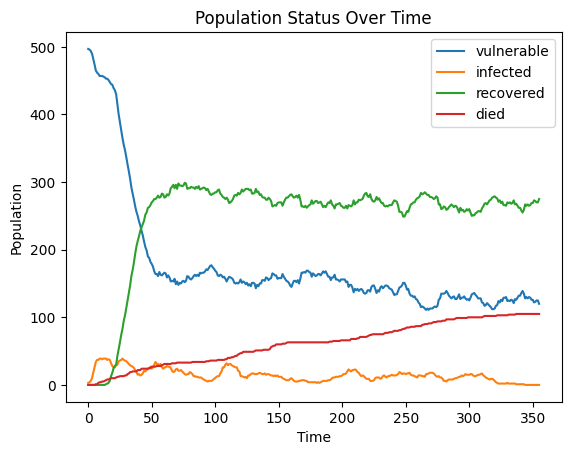

In [130]:
g = initNewGraph(500)
vulnerableHistory, infectedHistory, recoveredHistory, diedHistory = simulate(g, 356, quarantine, vaccine)

draw(vulnerableHistory, infectedHistory, recoveredHistory, diedHistory)